### 1. Import Dependecies

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Dict, List

# Set random seed
np.random.seed(42)

# Matplotlib config
plt.style.use('default')
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['figure.figsize'] = (10, 6)

### 2. PCA via Covariance Eigendecomposition

In [2]:
# Load data
df = pd.read_csv('../data/processed/CountryData_Preprocessed.csv')
df.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,1.291532,-1.138280,0.279088,-0.082455,-0.808245,0.157336,-1.619092,1.902882,-0.679180
1,-0.538949,-0.479658,-0.097016,0.070837,-0.375369,-0.312347,0.647866,-0.859973,-0.485623
2,-0.272833,-0.099122,-0.966073,-0.641762,-0.220844,0.789274,0.670423,-0.038404,-0.465376
3,2.007808,0.775381,-1.448071,-0.165315,-0.585043,1.387054,-1.179234,2.128151,-0.516268
4,-0.695634,0.160668,-0.286894,0.497568,0.101732,-0.601749,0.704258,-0.541946,-0.041817


Steps to implement PCA:
1. Compute Covariance Matrix
2. Computer Eigen Values
3. Project data into principal components

In [3]:
def compute_pca_cov(X: np.ndarray, k: int = 4, reference_scores: np.ndarray = None) -> Dict:
    """
    PCA via covariance matrix, scaled to match sklearn PCA output.
    """
    X_centered = X - np.mean(X, axis=0)
    cov_matrix = np.cov(X_centered.T)
    eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
    idx = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]
    V_k = eigenvectors[:, :k]
    scores = X_centered @ V_k
    scores_scaled = scores * np.sqrt(eigenvalues[:k])

    if reference_scores is not None:
        for i in range(k):
            if np.corrcoef(scores_scaled[:, i], reference_scores[:, i])[0, 1] < 0:
                scores_scaled[:, i] *= -1

    total_variance = np.sum(eigenvalues)
    explained_variance = eigenvalues[:k]
    explained_ratio = explained_variance / total_variance
    explained_cum = np.cumsum(explained_ratio)

    return {
        'components': V_k.T,
        'scores': scores_scaled,
        'eigenvalues': eigenvalues,
        'explained_variance': explained_variance,
        'explained_ratio': explained_ratio,
        'explained_cum': explained_cum,
        'total_variance': total_variance
    }

In [4]:
X_std = df.values
pca_result = compute_pca_cov(X_std, k=4)
scores = pca_result['scores']

 ### 3. Top Loadings Function

In [5]:
def top_loadings(components: np.ndarray, feature_names: List[str], top_n: int = 10) -> Dict:
    """
    Find top positive and negative loadings for each principal component.
    """
    results = {}
    for i, pc in enumerate(components):
        abs_loadings = np.abs(pc)
        top_indices = np.argsort(abs_loadings)[::-1][:top_n]
        pos_loadings = [(feature_names[j], pc[j]) for j in top_indices if pc[j] > 0]
        neg_loadings = [(feature_names[j], pc[j]) for j in top_indices if pc[j] < 0]
        results[f"PC{i+1}"] = {'positive': pos_loadings, 'negative': neg_loadings}
    return results

In [6]:
feature_names = df.columns.tolist()
loadings = top_loadings(pca_result['components'], feature_names, top_n=5)
for pc, vals in loadings.items():
    print(f"\n{pc} - Top Loadings")
    print("Positive:", vals['positive'])
    print("Negative:", vals['negative'])


PC1 - Top Loadings
Positive: [('life_expec', np.float64(0.4258393848285668)), ('income', np.float64(0.39844111157132395)), ('gdpp', np.float64(0.39264482415656254))]
Negative: [('child_mort', np.float64(-0.41951944871295893)), ('total_fer', np.float64(-0.4037289550283284))]

PC2 - Top Loadings
Positive: [('imports', np.float64(0.6718206442214822)), ('exports', np.float64(0.613163493591295)), ('child_mort', np.float64(0.1928839367133636))]
Negative: [('health', np.float64(-0.24308677913355803)), ('life_expec', np.float64(-0.2227067434188877))]

PC3 - Top Loadings
Positive: [('health', np.float64(0.5966323651917058)), ('imports', np.float64(0.2999267440781969))]
Negative: [('inflation', np.float64(-0.6425195144555437)), ('income', np.float64(-0.3015475010837702)), ('exports', np.float64(-0.14476069039195272))]

PC4 - Top Loadings
Positive: []
Negative: [('gdpp', np.float64(-0.5319945749959047)), ('health', np.float64(-0.4618974967691564)), ('income', np.float64(-0.39215903936585306)), (

### 4. Scree Plot & Cumulative Variance

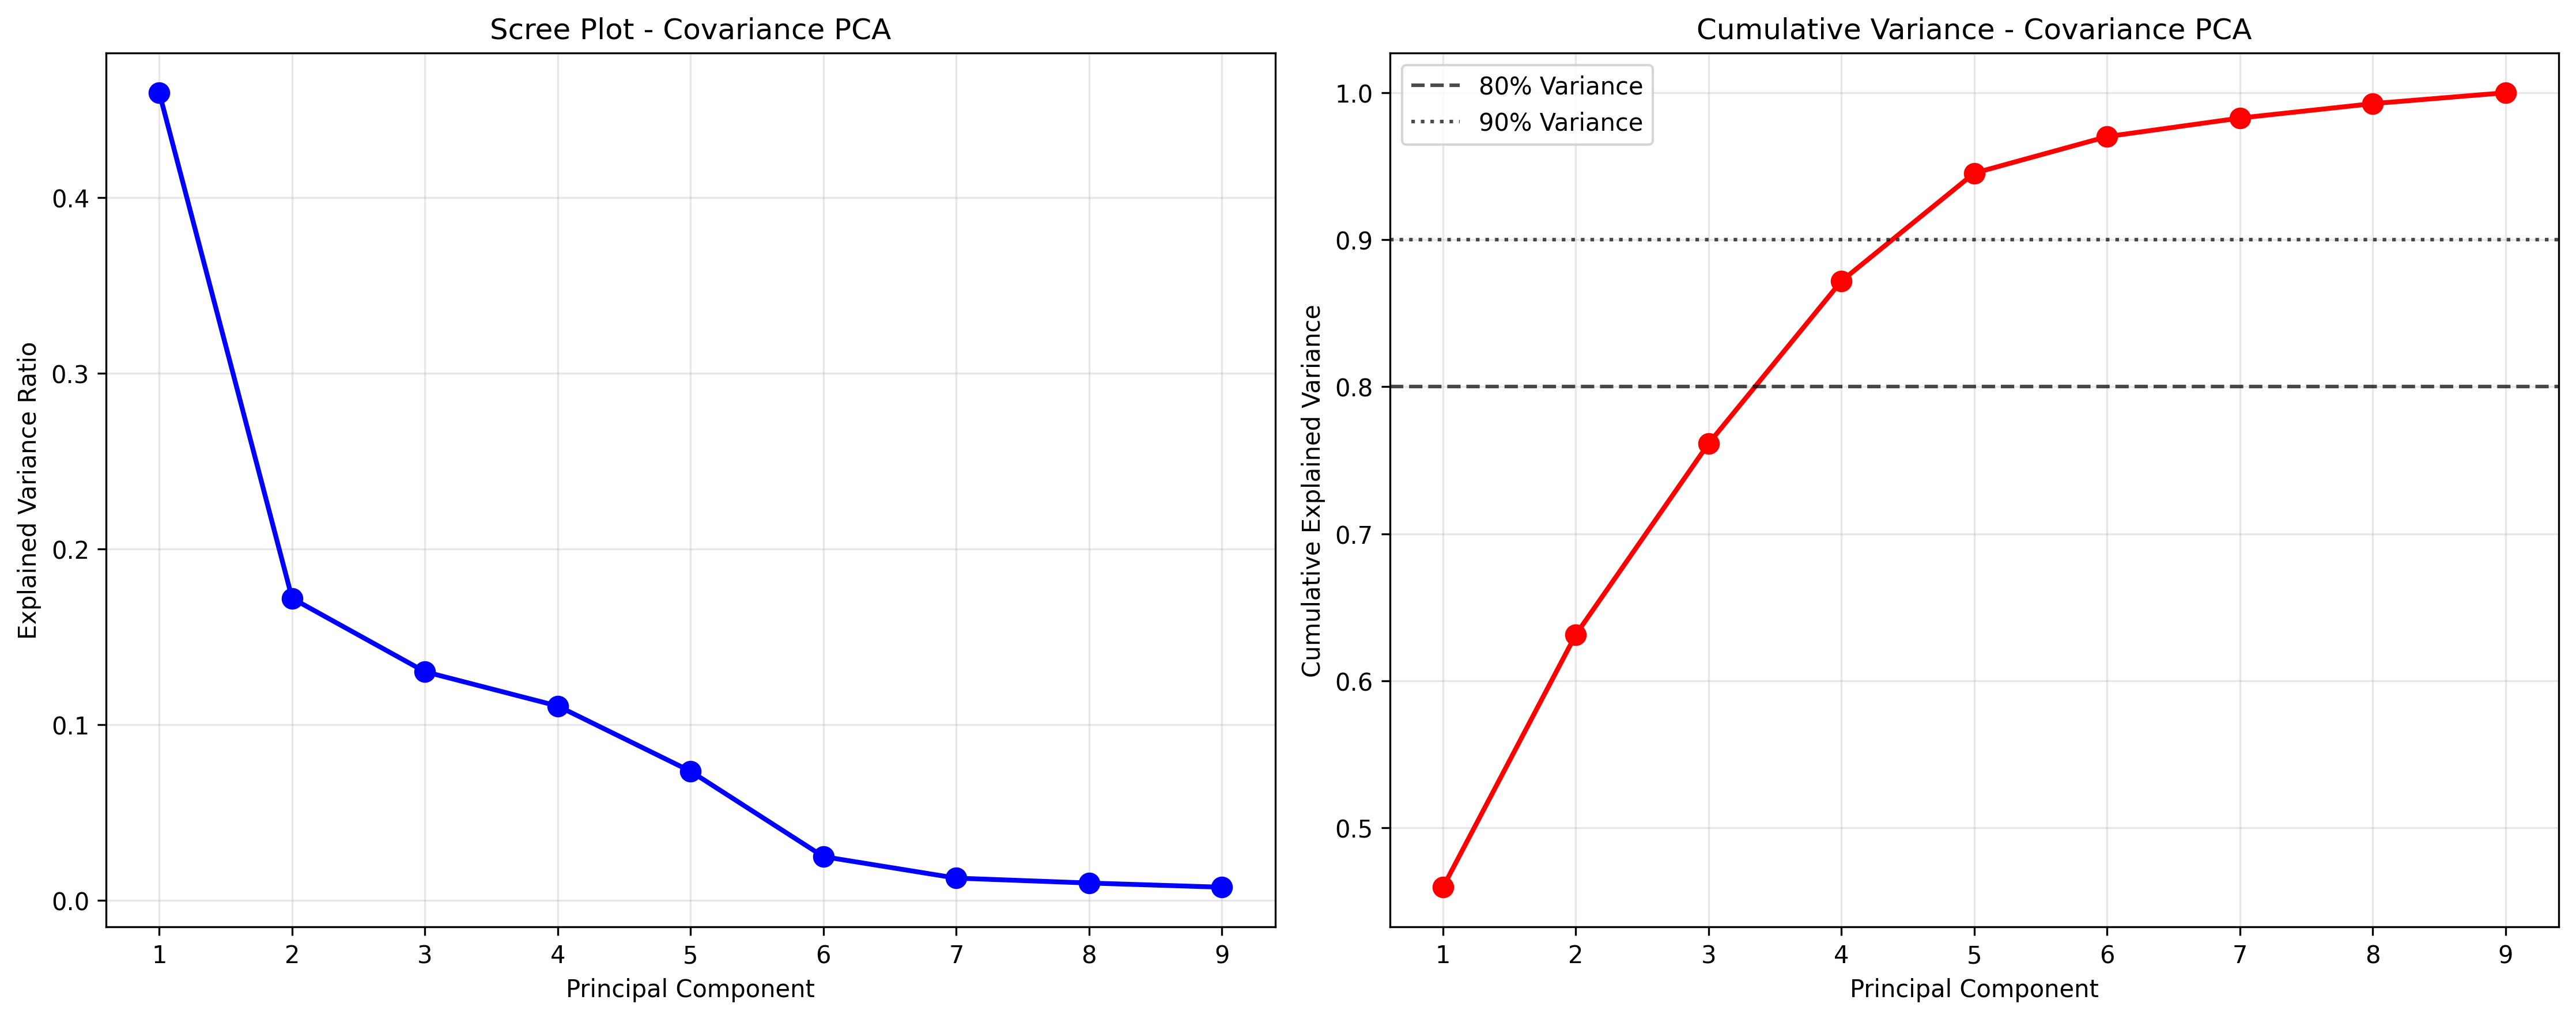

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
eigenvals = pca_result['eigenvalues']
explained_ratios = eigenvals / pca_result['total_variance']
cumulative_ratios = np.cumsum(explained_ratios)

ax1.plot(range(1, len(eigenvals)+1), explained_ratios, 'bo-', linewidth=2, markersize=8)
ax1.set_xlabel('Principal Component')
ax1.set_ylabel('Explained Variance Ratio')
ax1.set_title('Scree Plot - Covariance PCA')
ax1.grid(True, alpha=0.3)
ax1.set_xticks(range(1, len(eigenvals)+1))

ax2.plot(range(1, len(eigenvals)+1), cumulative_ratios, 'ro-', linewidth=2, markersize=8)
ax2.axhline(y=0.8, color='k', linestyle='--', alpha=0.7, label='80% Variance')
ax2.axhline(y=0.9, color='k', linestyle=':', alpha=0.7, label='90% Variance')
ax2.set_xlabel('Principal Component')
ax2.set_ylabel('Cumulative Explained Variance')
ax2.set_title('Cumulative Variance - Covariance PCA')
ax2.grid(True, alpha=0.3)
ax2.legend()
ax2.set_xticks(range(1, len(eigenvals)+1))

plt.tight_layout()
plt.savefig('../artifacts/figures/pca_cov_scree.png', dpi=300, bbox_inches='tight')
plt.show()

### 5. 2D Scatter Plot (PC1 vs PC2)

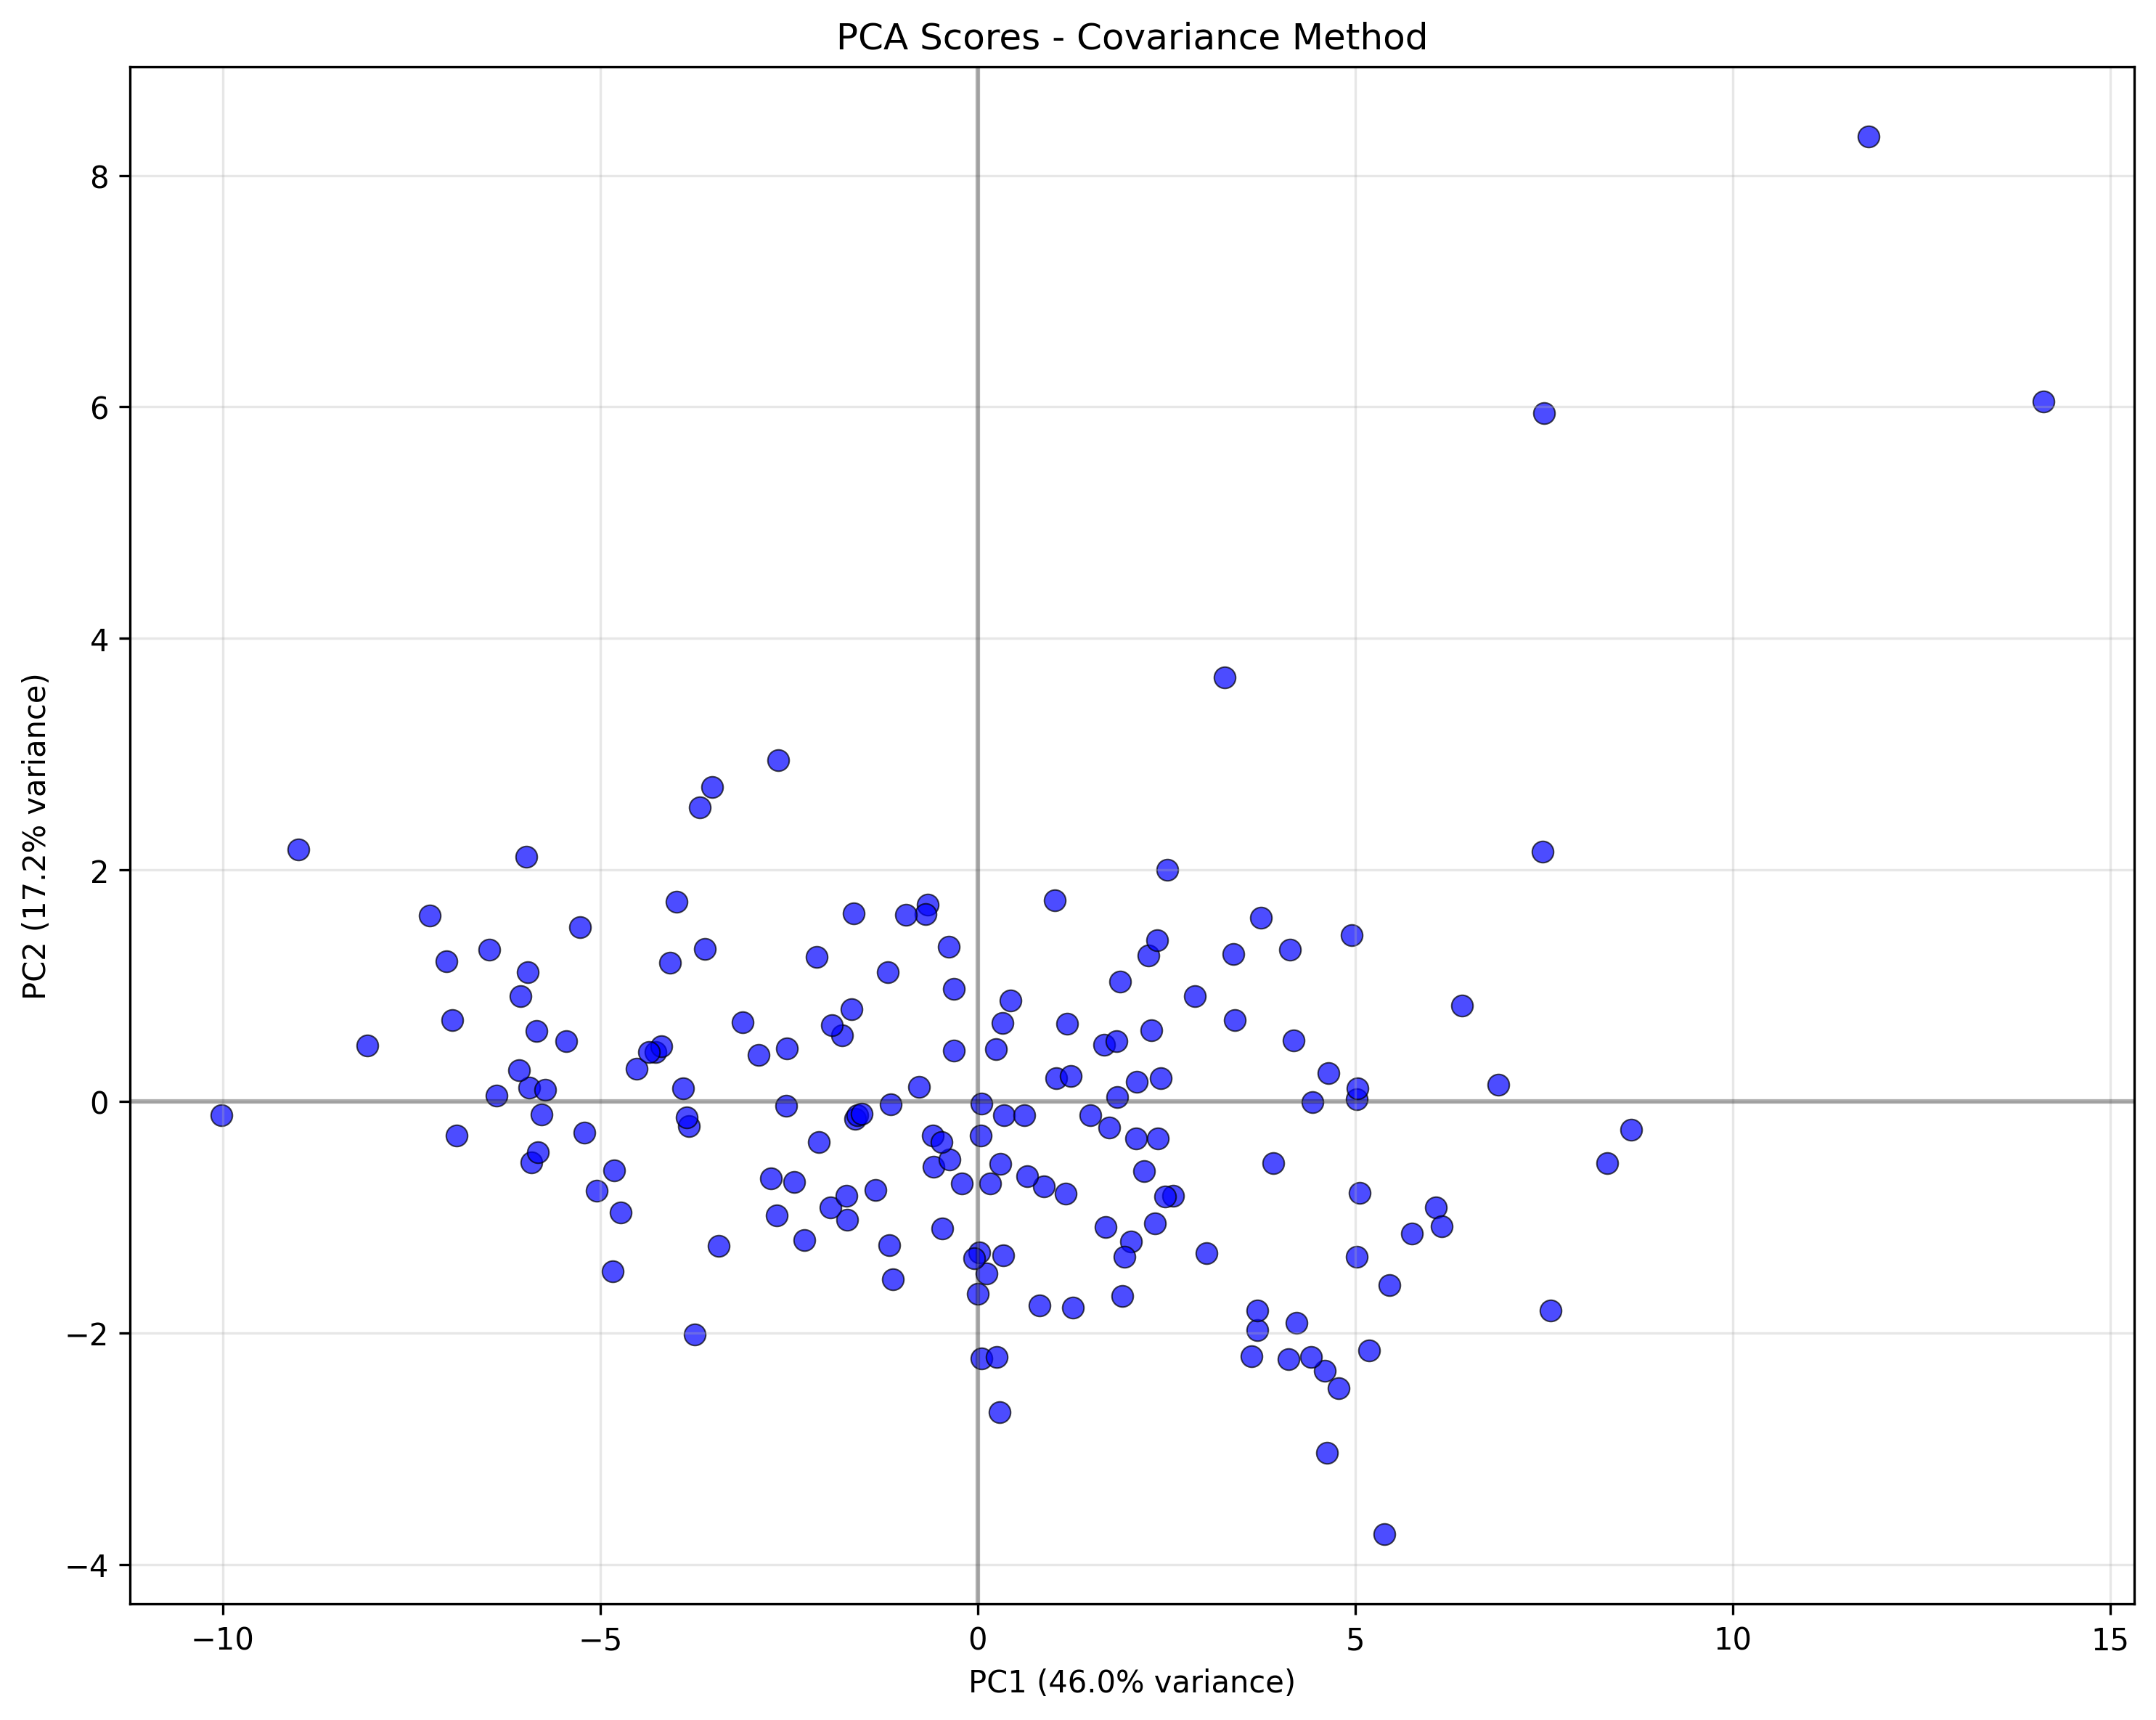

In [8]:
plt.figure(figsize=(10, 8))
plt.scatter(scores[:, 0], scores[:, 1], alpha=0.7, s=50, c='blue', edgecolors='black', linewidth=0.5)
plt.xlabel(f'PC1 ({pca_result["explained_ratio"][0]:.1%} variance)')
plt.ylabel(f'PC2 ({pca_result["explained_ratio"][1]:.1%} variance)')
plt.title('PCA Scores - Covariance Method')
plt.grid(True, alpha=0.3)
plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
plt.axvline(x=0, color='k', linestyle='-', alpha=0.3)
plt.tight_layout()
plt.savefig('../artifacts/figures/pca_cov_scatter.png', dpi=300, bbox_inches='tight')
plt.show()

### 6. Saving new data set

In [9]:
df_pca = pd.DataFrame(scores, columns=[f'PC{i+1}' for i in range(scores.shape[1])])
df_pca.head()

,PC1,PC2,PC3,PC4
0,-5.941835,0.119264,0.779228,-1.005645
1,0.876911,-0.733584,0.361864,1.161510
2,-0.581787,-0.567722,-1.325450,0.868452
3,-5.981402,2.114801,-1.654819,-0.839951
4,2.108234,0.170449,0.244929,0.847392


In [10]:
df_pca.to_csv('../data/processed/countries_pca_4components.csv', index=False)